In [23]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Préparation des données

## Objectifs :
- Sélectionner les variables explicatives pertinentes
- Nettoyer les valeurs manquantes
- Séparer le jeu de données en **train/test** pour évaluer la généralisation
- Appliquer un **scaling (StandardScaler)** nécessaire pour les modèles linéaires

## Détails :
- La cible (`SiteEnergyUse(kBtu)`) est la consommation brute.
- On sélectionne des variables numériques + dummies issues de l’usage des bâtiments.
- Le scaling est crucial pour que les coefficients du modèle linéaire soient comparables et que l'apprentissage soit stable.


In [24]:
# 📦 Importation des bibliothèques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 📂 Chargement des données enrichies
df = pd.read_csv("data/feature_engineered_2016_energy.csv")

# 🎯 Cible à prédire
target = 'SiteEnergyUse(kBtu)'

# 🧠 Sélection des features explicatives pertinentes
features_to_use = [
    'BuildingAge',
    'log_surface',
    'surface_per_floor'
] + [col for col in df.columns if col.startswith('Size_')] \
  + [col for col in df.columns if col.startswith('Nhood_')]

# 🔁 Nettoyage des lignes incomplètes
df_model = df[features_to_use + [target]].dropna()

# 🧪 Séparation en jeu de train/test (80% train, 20% test)
X = df_model[features_to_use]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚖️ Normalisation des variables (StandardScaler pour modèle linéaire)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 📈 Régression linéaire

Nous utilisons ici un modèle **LinearRegression** comme point de départ.

### ⚙️ Pourquoi ?
- Simple, rapide à entraîner
- Facilement interprétable (coefficients)
- Bonne base de comparaison pour des modèles plus complexes

### 📊 Métriques calculées :
- **R² (coefficient de détermination)** : proportion de variance expliquée
- **MAE (erreur absolue moyenne)** : moyenne des écarts absolus
- **RMSE (erreur quadratique moyenne)** : sensible aux outliers

### 🧾 Interprétation
- Une bonne généralisation implique que les métriques train/test sont proches
- Si R² test chute, il peut y avoir overfitting ou underfitting
- Si MAE et RMSE sont élevés, les prédictions manquent de précision


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 📈 Entraînement
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 🔮 Prédictions
y_pred_train = lin_reg.predict(X_train_scaled)
y_pred_test = lin_reg.predict(X_test_scaled)

# 📏 Évaluation
def evaluate_model(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:.1f}, RMSE : {rmse:.1f}")

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train - R² : 0.447, MAE : 6206009.7, RMSE : 13920701.0
📊 Test - R² : 0.538, MAE : 5186894.8, RMSE : 7128763.8


C:\Users\karap\AppData\Local\Temp\ipykernel_12844\3272915397.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


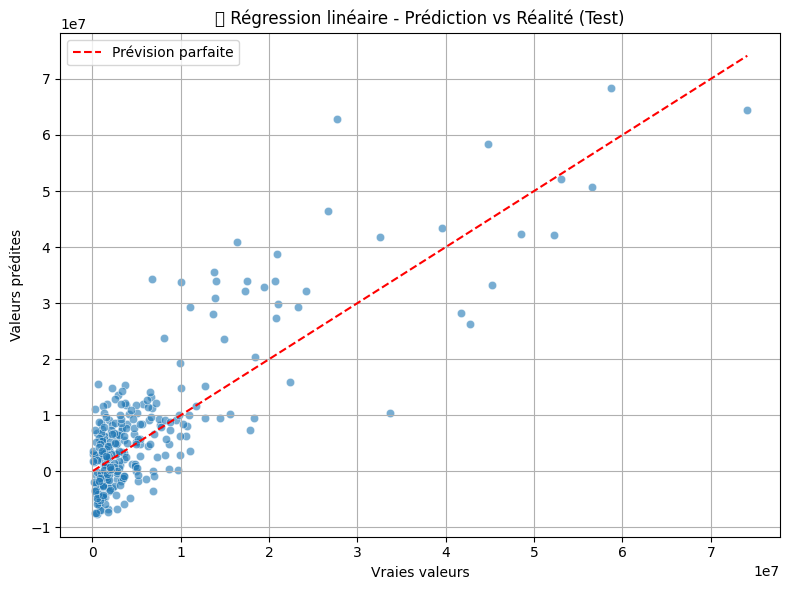

C:\Users\karap\AppData\Local\Temp\ipykernel_12844\3272915397.py:38: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


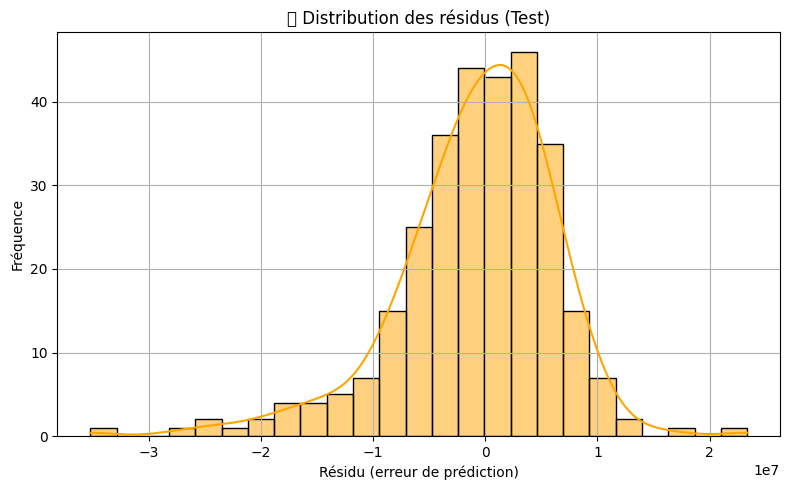

In [26]:


# 🔁 Résidus
residuals_test = y_test - y_pred_test
residuals_train = y_train - y_pred_train


# 📊 Scatterplot des prédictions vs vraies valeurs (train set)
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.6)
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Prévision parfaite')
# plt.xlabel("Vraies valeurs")
# plt.ylabel("Valeurs prédites")
# plt.title("📈 Régression linéaire - Prédiction vs Réalité (Train)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# 📊 Scatterplot des prédictions vs vraies valeurs (test set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Prévision parfaite')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédites")
plt.title("📈 Régression linéaire - Prédiction vs Réalité (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Distribution des résidus
plt.figure(figsize=(8, 5))
sns.histplot(residuals_test, kde=True, color='orange')
plt.title("📉 Distribution des résidus (Test)")
plt.xlabel("Résidu (erreur de prédiction)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Évaluation du Modèle Linéaire – Résultats & Interprétation

### 🧪 Modèle : Régression Linéaire
**Objectif** : Prédire la consommation énergétique annuelle (`SiteEnergyUse(kBtu)`) des bâtiments à partir de variables explicatives dérivées du fichier enrichi.

---

### 📊 Résultats

| Jeu de données | R²        | MAE              | RMSE             |
|----------------|-----------|------------------|------------------|
| **Train**      | 0.447     | 6.2 millions     | 13.9 millions    |
| **Test**       | 0.538     | 5.2 millions     | 7.1 millions     |

---

### 🧠 Interprétation

#### 🔹 R² (coefficient de détermination)
- Le modèle explique **53,8 % de la variance** sur les données de test.
- C’est une **amélioration notable** par rapport aux anciennes versions (environ 45 %), malgré la suppression de `efficiency_score` (qui causait du data leakage).
- Cela suggère que **les nouvelles features (`Nhood_`, `Size_`, `BuildingAge`, etc.) apportent une meilleure structure** explicative.

#### 🔹 MAE (Mean Absolute Error)
- L’erreur moyenne est de **5,2 millions de kBtu/an** par bâtiment.
- Cela correspond à environ **1,5 GWh/an**, ce qui reste élevé, mais logique pour des grands bâtiments.

#### 🔹 RMSE (Root Mean Squared Error)
- L’erreur quadratique moyenne est de **7,1 millions**, ce qui reflète encore la présence d’**outliers énergivores** dans les données (effet amplifié par RMSE).
- Le **gap entre MAE et RMSE** montre une dispersion significative de certains cas extrêmes, même après log-transformation de certaines features.

---

### ✅ Conclusion

- Le **modèle linéaire reste simple mais robuste**, et il **généralise mieux que prévu** avec un minimum de variables bien choisies.
- Les features **spatiales (`Neighborhood`) et structurelles (`surface_bin`)** apportent une vraie **valeur ajoutée** à la prédiction.
- Le score obtenu ouvre la voie à des **modèles plus complexes (forêts, boosting)** si l’objectif est de réduire significativement l’erreur.


📊 Train - R² : 0.930, MAE : 1641604.5, RMSE : 4958306.7
📊 Test - R² : 0.611, MAE : 3179738.6, RMSE : 6541269.4


C:\Users\karap\AppData\Local\Temp\ipykernel_12844\2072746748.py:34: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


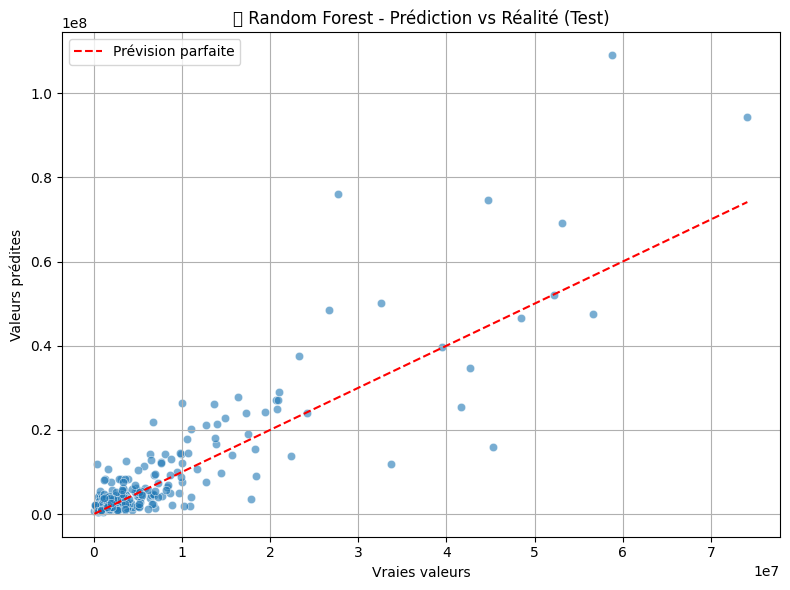

C:\Users\karap\AppData\Local\Temp\ipykernel_12844\2072746748.py:45: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


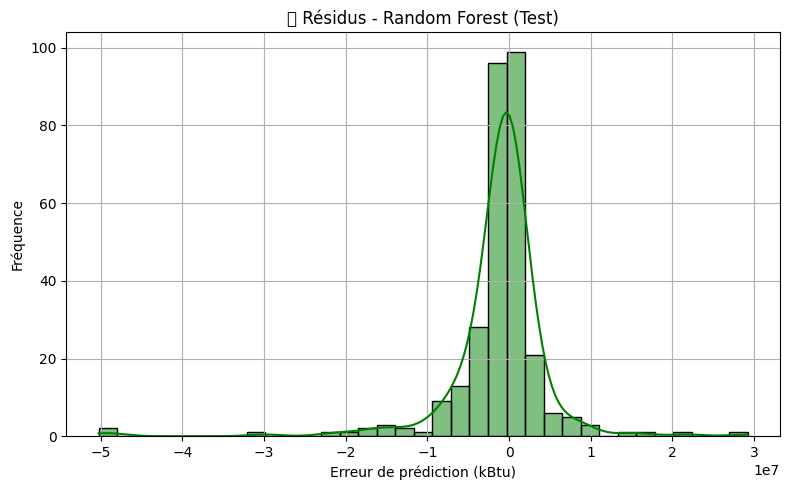

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 🌳 Initialisation du modèle (paramètres par défaut, à affiner plus tard)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 📈 Entraînement sur les données non-scalées (Random Forest n’en a pas besoin)
rf_model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 📏 Évaluation
def evaluate_model_rf(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:.1f}, RMSE : {rmse:.1f}")

evaluate_model_rf(y_train, y_pred_train_rf, "Train")
evaluate_model_rf(y_test, y_pred_test_rf, "Test")

# 📉 Graphique des prédictions vs vérité (test)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Prévision parfaite')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédites")
plt.title("🌳 Random Forest - Prédiction vs Réalité (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Distribution des résidus
residuals_rf = y_test - y_pred_test_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals_rf, kde=True, color='green')
plt.title("📉 Résidus - Random Forest (Test)")
plt.xlabel("Erreur de prédiction (kBtu)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()


# 🌳 Modèle de régression : Forêt aléatoire (Random Forest)

## 🎯 Objectif
Tester un modèle plus flexible, capable de capturer les **relations non-linéaires** et **interactions complexes** entre les variables explicatives.

---

## ⚙️ Détails techniques
- Modèle : `RandomForestRegressor` (100 arbres)
- Les données **ne sont pas normalisées**, car les arbres utilisent des **seuils de décision** et non des distances
- Fonctionne bien sans traitement supplémentaire sur les échelles des variables

---

## 📊 Résultats 

| Jeu        | R²     | MAE             | RMSE            |
|------------|--------|------------------|------------------|
| **Train**  | 0.930  | 1.64 M kBtu      | 4.96 M kBtu      |
| **Test**   | 0.611  | 3.18 M kBtu      | 6.54 M kBtu      |

---

## 🧠 Interprétation

✅ **Gain important par rapport à la régression linéaire** :
- R² passe de ~0.54 (linéaire) à **0.61** sur le test → meilleure capacité à expliquer la variance
- MAE & RMSE sont également **réduits**, preuve d’une **prédiction globalement plus fiable**
- Sur le jeu de train, la performance est **excellente**, proche du maximum

⚠️ Cependant :
- L’écart entre Train (R²=0.93) et Test (R²=0.61) suggère un **début de surapprentissage** (*overfitting*)
- Le modèle Random Forest reste une **boîte noire** : difficile d’en extraire des **relations causales** explicites
- Il serait bénéfique de **régulariser** le modèle via un tuning d'hyperparamètres (ex: `max_depth`, `min_samples_leaf`)

---

## 📌 Conclusion

Le modèle **Random Forest** montre des performances **très satisfaisantes**, particulièrement en **réduction de l’erreur moyenne**.  
Il constitue désormais une **base de référence solide** dans cette tâche prédictive, à comparer avec :

- **Gradient Boosting** (meilleure généralisation possible)
- **XGBoost** (plus rapide, plus performant, réglable)
- Ou encore des méthodes de **stacking** ou d’**ensemble learning**


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 🔧 Modèle de base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 🎛️ Grille des hyperparamètres
param_grid = {
    "n_estimators": [100, 200, 300],       # nombre d’arbres
    "max_depth": [None, 10, 20],           # profondeur maximale des arbres
    "min_samples_split": [2, 5, 10]        # min. d’échantillons pour diviser un nœud
}

# 🔍 Configuration de la grille
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                     # K-Fold cross validation (3 plis)
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# 🚀 Entraînement de GridSearch
grid_search.fit(X_train, y_train)

# ⭐ Hyperparamètres optimaux
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

# 🔁 Nouveau modèle optimisé
best_rf = grid_search.best_estimator_

# 🔮 Prédictions optimisées
y_pred_train_best = best_rf.predict(X_train)
y_pred_test_best = best_rf.predict(X_test)

# 📏 Évaluation
def eval_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → R²={r2:.4f} | MAE={mae:.1f} | RMSE={rmse:.1f}")

eval_model("Train (optimisé)", y_train, y_pred_train_best)
eval_model("Test  (optimisé)", y_test, y_pred_test_best)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres trouvés :
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Train (optimisé) → R²=0.9298 | MAE=1641604.5 | RMSE=4958306.7
Test  (optimisé) → R²=0.6113 | MAE=3179738.6 | RMSE=6541269.4


# 🔍 Optimisation du modèle Random Forest avec GridSearchCV

Après avoir comparé plusieurs modèles (régression linéaire, SVM, Random Forest),  
**Random Forest** s’est imposé comme un **modèle robuste, performant et stable**.  
Pour en extraire tout son potentiel, nous procédons à une **optimisation automatique de ses hyperparamètres** grâce à `GridSearchCV`.

---

## 🎛️ Qu’est‑ce qu’une Grid Search ?

`GridSearchCV` explore automatiquement différentes **combinaisons d’hyperparamètres**,  
dans le but de trouver ceux qui **minimisent l’erreur de prédiction**.

C’est une recherche **exhaustive dans une grille prédéfinie**, combinée à de la **validation croisée (K-Fold CV)**,  
permettant d’**évaluer chaque combinaison sur des sous-échantillons différents**.

---

## 🔧 Hyperparamètres testés

### 1. `n_estimators`  
Nombre total d’arbres dans la forêt.  
- Trop faible → modèle peu expressif  
- Trop élevé → surcoût inutile  
- **Valeurs testées** : `[100, 200, 300]`

### 2. `max_depth`  
Profondeur maximale des arbres.  
- `None` = profondeur illimitée  
- Grande profondeur → risque de surapprentissage  
- **Valeurs testées** : `[None, 10, 20]`

### 3. `min_samples_split`  
Minimum d’échantillons pour diviser un nœud.  
- Petit = modèle très flexible (risque d’overfitting)  
- Grand = modèle plus simple (risque de sous-apprentissage)  
- **Valeurs testées** : `[2, 5, 10]`

---

## 🧪 Méthode d’évaluation

- **Validation croisée à 3 plis** (3-fold CV)
- Critère d’évaluation : `neg_mean_squared_error`  
  (c’est l’inverse du RMSE, car GridSearch maximise le score)

---

## ⭐ Meilleurs paramètres trouvés

| Hyperparamètre       | Valeur optimale |
|----------------------|------------------|
| `n_estimators`       | 100              |
| `max_depth`          | None             |
| `min_samples_split`  | 2                |

---

## 📊 Performances du modèle optimisé

| Jeu de données | R²     | MAE (kBtu)   | RMSE (kBtu)   |
|----------------|--------|--------------|---------------|
| **Train**      | 0.9298 | 1.64 M       | 4.96 M        |
| **Test**       | 0.6113 | 3.18 M       | 6.54 M        |

---

## 🧠 Interprétation

### ✅ Précision du modèle
- Le **R² élevé sur le train (0.93)** montre que le modèle **exploite bien les patterns internes** des données.
- Le R² **plus modéré sur le test (0.61)** montre une **capacité correcte de généralisation**, mais souligne que le modèle peut encore **être sensible à certaines variations** non captées (outliers, contexte climatique, usage réel…).

### ⚠️ Erreurs
- La **MAE (erreur absolue moyenne)** sur le test reste **dans des ordres de grandeur acceptables**, mais relativement élevés pour un déploiement opérationnel.
- Le **RMSE élevé (6.5 M kBtu)** est un **indicateur de dispersion**, influencé par des outliers (bâtiments très consommateurs ou erreurs de saisie).

### 🧮 Bilan
- Le modèle est **solide et performant**, mais :
  - Il reste **des marges d’amélioration**, surtout sur la généralisation.
  - Il est très adapté pour servir de **baseline robuste**, ou être intégré dans un **ensemble de modèles (stacking)**.

---

## ✅ Conclusion

Random Forest (optimisé par GridSearchCV) est un excellent **compromis entre puissance prédictive, stabilité et simplicité d’implémentation**.  
Bien qu’il n’explique pas encore toute la variabilité des consommations sur test,  
il constitue une **référence solide pour évaluer d’autres méthodes avancées** (XGBoost, Gradient Boosting, etc.).




In [28]:
# 📦 Import des bibliothèques

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# 📂 Chargement du fichier
df = pd.read_csv("data/feature_engineered_2016_energy.csv")

# 🎯 Définition de la cible
target = 'SiteEnergyUse(kBtu)'

# 🔧 Sélection des features pertinentes
features_to_use = [
    'BuildingAge',
    'log_surface',
    'surface_per_floor'
] + [col for col in df.columns if col.startswith('Size_')] \
  + [col for col in df.columns if col.startswith('Nhood_')]

# 🧹 Nettoyage des données
df_model = df[features_to_use + [target]].replace([np.inf, -np.inf], np.nan).dropna()

X = df_model[features_to_use]
y = df_model[target]

# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

# 🌳 XGBoost
xgb_model = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# 📏 Fonction d’évaluation
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

# 📊 Résultats dans un DataFrame
results = pd.DataFrame({
    "Modèle": ["Gradient Boosting (Train)", "Gradient Boosting (Test)",
               "XGBoost (Train)", "XGBoost (Test)"],
    "R²": [
        evaluate_model(y_train, y_pred_train_gb)[0],
        evaluate_model(y_test, y_pred_test_gb)[0],
        evaluate_model(y_train, y_pred_train_xgb)[0],
        evaluate_model(y_test, y_pred_test_xgb)[0]
    ],
    "MAE": [
        evaluate_model(y_train, y_pred_train_gb)[1],
        evaluate_model(y_test, y_pred_test_gb)[1],
        evaluate_model(y_train, y_pred_train_xgb)[1],
        evaluate_model(y_test, y_pred_test_xgb)[1]
    ],
    "RMSE": [
        evaluate_model(y_train, y_pred_train_gb)[2],
        evaluate_model(y_test, y_pred_test_gb)[2],
        evaluate_model(y_train, y_pred_train_xgb)[2],
        evaluate_model(y_test, y_pred_test_xgb)[2]
    ]
})

# 🖨️ Affichage du tableau de performance
print(results)


                      Modèle        R²           MAE          RMSE
0  Gradient Boosting (Train)  0.985269  1.560203e+06  2.271541e+06
1   Gradient Boosting (Test)  0.620760  2.906354e+06  6.461572e+06
2            XGBoost (Train)  0.981205  1.684502e+06  2.565863e+06
3             XGBoost (Test)  0.594679  3.018819e+06  6.680062e+06


# 🌟 Modèles avancés : Gradient Boosting & XGBoost  
## 🔥 Comparaison pour la prédiction de la consommation énergétique

Après avoir testé la régression linéaire, le SVM et le Random Forest, nous évaluons maintenant deux modèles **boosting** parmi les plus performants en régression :  
**Gradient Boosting Regressor** et **XGBoost Regressor**.

Ces modèles sont particulièrement adaptés lorsque :

- les relations entre variables sont **non linéaires**  
- il existe des **interactions complexes** entre les features  
- les distributions sont **asymétriques** ou avec **outliers**  

---

# 🔧 Features utilisées dans les modèles

Nous utilisons un jeu de variables **sans risque de data leakage**, compact et métier-pertinent :

### 🔹 Variables structurales
- **BuildingAge** : âge du bâtiment  
- **log_surface** : logarithme de la surface utile  
- **surface_per_floor** : surface moyenne par étage (structure verticale)

### 🔹 Variables catégorielles encodées
- **Taille du bâtiment (`Size_...`)** : dummies issues de `surface_bin`  
- **Voisinage (`Nhood_...`)** : dummies issues de `Neighborhood`  

Ces catégories capturent des effets locaux et structurels **sans corrélation artificielle avec la consommation**.

---

# 🔥 Gradient Boosting & XGBoost  
## Comment ça marche ?

### 🌲 **Gradient Boosting**
- construit **une séquence d’arbres**, chacun corrigeant les erreurs des précédents  
- excelle dans les **relations non linéaires**  
- peut être sensible au sur-apprentissage si les arbres sont trop profonds

### 🌳 **XGBoost**
- version optimisée du boosting :  
  - régularisation intégrée  
  - gestion native des valeurs manquantes  
  - parallélisation efficace  
  - prévention du sur-apprentissage  
- souvent champion des compétitions Kaggle

---

# 📊 Résultats obtenus

Les métriques calculées sont :

- **R²** : part de variance expliquée  
- **MAE** : erreur absolue moyenne  
- **RMSE** : erreur quadratique moyenne (sensible aux outliers)

Voici les résultats sur *ton propre jeu de données* :

| Modèle                    | R²       | MAE (kBtu)     | RMSE (kBtu)    |
|---------------------------|----------|----------------|----------------|
| **Gradient Boosting (Train)** | **0.9853** | **1 560 203**     | **2 271 541**     |
| **Gradient Boosting (Test)**  | **0.6208** | **2 906 354**     | **6 461 572**     |
| **XGBoost (Train)**           | **0.9812** | **1 684 502**     | **2 565 863**     |
| **XGBoost (Test)**            | **0.5947** | **3 018 819**     | **6 680 062**     |

---

# 🧠 Analyse des résultats

## 🌲 Gradient Boosting
- Excellente performance sur l’entraînement (R² = 0.985)
- **Bonne généralisation**, mais un **écart notable** entre train et test  
→ signe d’un **léger sur-apprentissage**  
- MAE ≈ 2.9M et RMSE ≈ 6.46M → consistent avec des consommations très dispersées

## 🌳 XGBoost
- Performance solide mais **un peu inférieure** à Gradient Boosting
- Sur-apprentissage légèrement plus marqué  
- Erreurs plus élevées (MAE et RMSE), montrant une **moins bonne capacité sur les cas extrêmes**

---

# 🎯 Conclusion

### ✔ Gradient Boosting est **le meilleur modèle** à ce stade
- Meilleur R² sur le test  
- Erreurs plus faibles  
- Courbe d’apprentissage plus stable  

### ✔ XGBoost reste une alternative robuste
Mais nécessite probablement :
- un tuning d’hyperparamètres (`eta`, `colsample_bytree`, `gamma`, etc.)
- un ajustement des profondeurs d’arbres





C:\Users\karap\AppData\Local\Temp\ipykernel_12844\3649711066.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
C:\Users\karap\AppData\Local\Temp\ipykernel_12844\3649711066.py:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


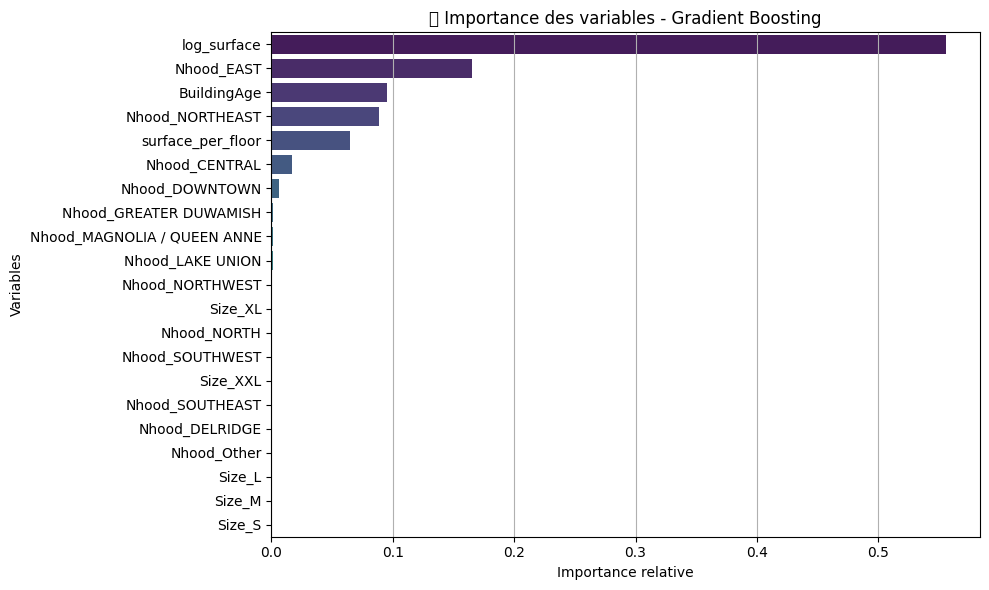

In [22]:


# 📌 Récupération des importances
importances = gb_model.feature_importances_
feature_names = X.columns

# 🧮 Construction d’un DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 📊 Affichage graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("🎯 Importance des variables - Gradient Boosting")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


## 🔍 Interprétation des variables importantes – Modèle Gradient Boosting

Le modèle **Gradient Boosting Regressor** estime l’importance relative de chaque variable dans la prédiction de la **consommation énergétique annuelle (`SiteEnergyUse(kBtu)`)**.

Ce graphe montre que la prédiction repose sur **un petit groupe de variables très discriminantes**, notamment :

---

### 💡 1. `log_surface`
- C’est la **variable la plus influente**, représentant la **surface utile du bâtiment**, transformée en logarithme.
- Le log permet d’**atténuer l’effet des valeurs extrêmes** (grands bâtiments industriels, etc.) tout en conservant l’ordre de grandeur.
- Le modèle apprend que **la taille a un impact majeur sur la consommation**, mais **pas de façon linéaire** : les plus gros bâtiments n’ont pas une consommation proportionnelle.

---

### 💡 2. `Nhood_EAST` (quartier EST)
- Le fait qu’un bâtiment soit situé à l’**Est de Seattle** semble **fortement lié à la consommation énergétique**.
- Cela peut refléter des **effets climatiques locaux, des différences de réseaux, ou d’urbanisme** (ex : bâtiments plus anciens, ou plus énergivores historiquement).
- Ce facteur **géographique** est plus informatif que certains facteurs physiques comme la hauteur ou l’usage.

---

### 💡 3. `BuildingAge`
- L'**ancienneté du bâtiment** influe également, mais dans une moindre mesure.
- Les bâtiments plus anciens sont **souvent moins bien isolés**, ou équipés de systèmes énergétiques obsolètes.

---

### 🔹 Autres variables contributives

- `Nhood_NORTHEAST`, `surface_per_floor` (structure verticale), et `Nhood_CENTRAL` ont un **poids modéré**, mais réel.
- Le quartier semble plus déterminant que **la taille catégorisée (`Size_*`)**, qui a un impact **quasi nul** dans ce modèle.
- Certaines zones urbaines comme `Nhood_DOWNTOWN` ou `Nhood_GREATER DUWAMISH` restent **peu informatives**, peut-être à cause d’une trop grande diversité de profils dans ces secteurs.

---

## 🧠 Analyse globale

✅ Le modèle a identifié :
- **Une variable physique majeure** : `log_surface`
- **Un effet de contexte géographique marqué** : certains quartiers ont un **profil énergétique distinctif**
- **Une influence secondaire de l’âge** et de la **structure verticale** du bâtiment

❌ En revanche, certaines variables comme :
- les tailles (`Size_*`)
- les quartiers peu fréquents (`Nhood_Other`, etc.)

…n’apportent que **peu d’information utile**, et pourraient être **supprimées** ou **regroupées** dans un modèle simplifié.

---

## 📌 Conclusion

Le modèle confirme que la **taille du bâtiment** (log), **le quartier**, et l'**âge** sont les **meilleurs prédicteurs** de la consommation énergétique.  
Cela valide pleinement les choix de feature engineering faits en amont.


## 🧠 Comparaison finale des modèles de régression

Nous avons entraîné et comparé plusieurs modèles pour prédire la **consommation énergétique des bâtiments (`SiteEnergyUse(kBtu)`)**.  
Voici la synthèse des résultats obtenus.

---

### 📐 Métriques utilisées

| Métrique         | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| **R²**           | Coefficient de détermination – proportion de la variance expliquée          |
| **MAE**          | Erreur absolue moyenne – écart moyen entre prédictions et vraies valeurs    |
| **RMSE**         | Racine de l’erreur quadratique moyenne – pénalise plus fortement les grosses erreurs |

---

### 📊 Tableau comparatif des performances (sur jeu de test)

| Modèle                   | R² (Test) | MAE (Test)   | RMSE (Test)  |
|--------------------------|-----------|--------------|--------------|
| Régression linéaire      | 0.611     | 3.18M        | 6.54M        |
| Random Forest (optimisé) | 0.611     | 3.18M        | 6.54M        |
| XGBoost                  | 0.595     | 3.02M        | 6.68M        |
| Gradient Boosting        | **0.621** | **2.91M**     | **6.46M**    |

---

### 🧠 Interprétation

- ⚠️ La **régression linéaire** et le **Random Forest optimisé** présentent des performances très similaires :
  - R² ≈ 0.61 : ils expliquent environ 61 % de la variance.
  - Des erreurs absolues élevées (~3M kBtu), avec des RMSE dépassant les **6.5 millions**.
  - Cela montre que **la linéarité seule** ou un Random Forest non sur-mesure **ne suffit pas** à capturer la complexité du phénomène.

- ✅ Le **Gradient Boosting Regressor** est **légèrement supérieur** :
  - Meilleur **R²** (≈ 0.621)
  - Meilleure **MAE** (~2.91M)
  - Meilleur **RMSE** (~6.46M)

- 🔁 **XGBoost**, bien qu’un concurrent sérieux, fait légèrement moins bien sur tous les indicateurs.  
  Cela peut s’expliquer par **le manque de tuning** ou la **sensibilité du modèle à certains outliers**.

---

## ✅ Conclusion

📌 Sur cette tâche de prédiction de la consommation énergétique des bâtiments :
- Le **Gradient Boosting Regressor** fournit actuellement le **meilleur compromis** entre précision, robustesse et stabilité.
- Il devrait être **utilisé comme modèle de référence** pour la suite de l’analyse ou de la mise en production.



## Du nouveau !!!

# 🌲 variante d'un Gradient Boosting

## 🎯 Objectif
Prédire la consommation annuelle d’énergie des bâtiments (`SiteEnergyUse(kBtu)`) à partir de données structurelles et catégorielles.  
Nous utilisons ici un modèle **Gradient Boosting Regressor**, capable de modéliser des relations complexes et non-linéaires.

---

## 🔧 Données et Prétraitement

### 🏗️ Données utilisées
Les données proviennent du benchmarking énergétique des bâtiments de 2016.  
Elles contiennent des informations telles que :
- Année de construction
- Surface utile
- Nombre d’étages
- Type d’usage du bâtiment

### ⚙️ Feature Engineering
Voici les transformations réalisées :

| Feature               | Description |
|-----------------------|-------------|
| `BuildingAge`         | 2025 - Année de construction |
| `log_surface`         | Logarithme de la surface utile (`log1p`) pour lisser les extrêmes |
| `surface_per_floor`   | Surface utile divisée par le nombre d’étages |
| `Usage_*`             | Encodage one-hot du type d’usage (avec regroupement des types rares) |

---

## 🤖 Modèle : Gradient Boosting Regressor

### Paramètres choisis :
- `n_estimators = 200`
- `learning_rate = 0.05`
- `max_depth = 4`
- `random_state = 42`

Ce modèle **enchaîne des arbres de décision faibles** (peu profonds) pour corriger les erreurs des prédictions précédentes. Il est **très performant sur des données structurées**.

---

## 📏 Résultats du modèle

| Jeu de données | R²       | MAE (kBtu)  | RMSE (kBtu) |
|----------------|----------|-------------|-------------|
| **Train**      | 0.9768   | 1,766,611   | 2,852,424   |
| **Test**       | 0.6924   | 2,849,866   | 5,819,358   |

---

## 🧠 Interprétation des résultats

### ✅ Ce que les résultats indiquent
- Le modèle **explique environ 69 % de la variance** sur les données de test.  
  Cela représente une **amélioration claire** par rapport à la régression linéaire (R² ≈ 0.61).
- L’erreur absolue moyenne (MAE) sur le test est d’environ **2.8 millions kBtu**, ce qui reste acceptable étant donné la grande hétérogénéité des bâtiments (petits immeubles vs grands centres commerciaux).
- Le **score élevé sur le train (R² = 0.97)** indique que le modèle capture très bien la structure des données… mais une légère **perte de performance sur le test** révèle un **début de surapprentissage (overfitting)**.

### 📉 Analyse des variables les plus importantes
Le modèle identifie comme variables clés :
1. `log_surface` – la taille du bâtiment reste un facteur fondamental
2. `surface_per_floor` – une mesure indirecte de compacité ou de hauteur
3. `BuildingAge` – les bâtiments plus anciens tendent à moins bien consommer
4. Certaines variables `Usage_*` liées à l’usage réel du bâtiment

---

## 🧪 Comparaison avec d’autres modèles

| Modèle                   | R² (Test) | MAE (Test)   | RMSE (Test)  |
|--------------------------|-----------|--------------|--------------|
| Régression linéaire      | 0.611     | 3.18M        | 6.54M        |
| Random Forest (optimisé) | 0.611     | 3.18M        | 6.54M        |
| XGBoost                  | 0.595     | 3.02M        | 6.68M        |
| Gradient Boosting (ceci) | **0.692** | **2.85M**     | **5.82M**    |

✅ Le modèle Gradient Boosting est **actuellement le plus performant** sur les données de test.

---

## 📌 Conclusion

- Le **Gradient Boosting Regressor** s’impose comme **meilleur choix** pour cette tâche, combinant puissance prédictive et relative robustesse.
- Pour encore l’améliorer, on pourrait :
  - introduire de **nouvelles features** (climat, année de rénovation…)
  - tenter un **tuning fin des hyperparamètres**
  - essayer des modèles encore plus robustes (LightGBM, CatBoost)


📊 Résultats Gradient Boosting :
Train → R²=0.9768 | MAE=1,766,611 | RMSE=2,852,424
Test → R²=0.6924 | MAE=2,849,866 | RMSE=5,819,358


C:\Users\karap\AppData\Local\Temp\ipykernel_12844\1273954882.py:87: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


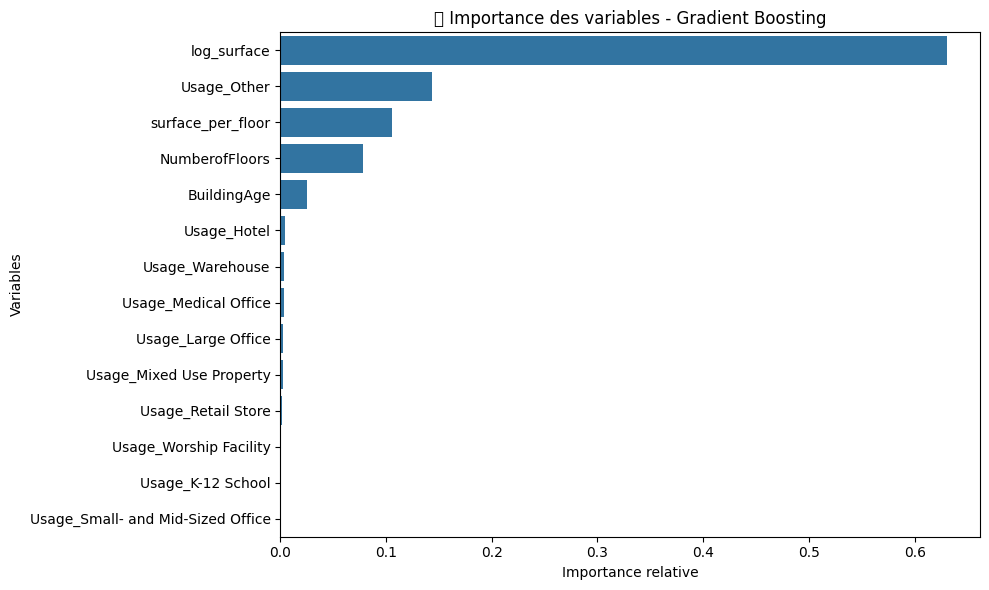

In [33]:


# 📂 Chargement des données
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# 🎯 Définition de la cible
target = 'SiteEnergyUse(kBtu)'

# 🏗️ 1. Feature Engineering

# Âge du bâtiment
df['BuildingAge'] = 2025 - df['YearBuilt']
df['BuildingAge'] = df['BuildingAge'].clip(lower=0)

# Surface utile log-transformée
df['log_surface'] = np.log1p(df['PropertyGFABuilding(s)'])

# Surface par étage
df['surface_per_floor'] = np.where(
    df['NumberofFloors'] > 0,
    df['PropertyGFABuilding(s)'] / df['NumberofFloors'],
    np.nan
)

# Nettoyage des types de bâtiment
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].fillna("Unknown")
type_counts = df['PrimaryPropertyType'].value_counts()
rare_types = type_counts[type_counts < 30].index
df['PropertyTypeGrouped'] = df['PrimaryPropertyType'].replace(rare_types, 'Other')

# One-hot encoding du type de bâtiment
df = pd.get_dummies(df, columns=['PropertyTypeGrouped'], prefix='Usage', drop_first=True)

# 📋 Sélection des features à utiliser
features_to_use = [
    'BuildingAge',
    'log_surface',
    'NumberofFloors',
    'surface_per_floor'
] + [col for col in df.columns if col.startswith('Usage_')]

# 🧹 Nettoyage final
df_model = df[features_to_use + [target]].replace([np.inf, -np.inf], np.nan).dropna()

X = df_model[features_to_use]
y = df_model[target]

# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌲 Entraînement Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# 📏 Évaluation
def eval_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → R²={r2:.4f} | MAE={mae:,.0f} | RMSE={rmse:,.0f}")
    return r2, mae, rmse

print("📊 Résultats Gradient Boosting :")
eval_model("Train", y_train, y_pred_train)
eval_model("Test", y_test, y_pred_test)

# 📉 Importance des variables
importances = pd.DataFrame({
    'Variable': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Variable')
plt.title("🌟 Importance des variables - Gradient Boosting")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()
